In [50]:
import os
import numpy as np
import pandas as pd

In [41]:
from sklearn.model_selection import train_test_split

In [29]:
BASE_DIR = 'data'

RATINGS_CSV = 'ratings.csv'
USERS_CSV = 'users.csv'
MOVIES_CSV = 'movies.csv'

In [20]:
ratings = pd.read_csv(os.path.join(BASE_DIR, RATINGS_CSV))

In [27]:
users = pd.read_csv(os.path.join(BASE_DIR, USERS_CSV))

In [88]:
num_users = users.userid.max()

In [30]:
movies = pd.read_csv(os.path.join(BASE_DIR, MOVIES_CSV))

In [86]:
num_movies = movies.movieid.max()

In [89]:
num_users, num_movies

(6040, 3952)

In [43]:
train_df, test_df = train_test_split(ratings,
                                     stratify=ratings['userid'],
                                     test_size=0.1,
                                     random_state=1)

In [46]:
len(train_df), len(test_df)

(900188, 100021)

In [90]:
train_np = np.zeros((num_users, num_movies))

In [92]:
for (_, _, userid, movieid, rating) in ratings.itertuples():
    train_np[userid - 1, movieid - 1] = rating

In [93]:
train_np.shape

(6040, 3952)

## Model

In [119]:
import keras
from keras import backend as K
from keras import Input, Model
from keras import regularizers
from keras.layers import Dense
from keras.regularizers import l2
from keras.optimizers import Adam, RMSprop

In [117]:
def masked_rmse(y_true, y_pred):
    # masked function
    mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
    # masked squared error
    masked_squared_error = K.square(mask_true * (y_true - y_pred))
    masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
    return masked_mse

In [137]:
# test masked rmse loss
y_true = K.constant([[ 0, 0, 1, 1]])
y_pred = K.constant([[ 1, 1, 1, 3]])

true = K.eval(y_true)
pred = K.eval(y_pred)

K.eval(masked_rmse(y_true, y_pred))


array([1.4142135], dtype=float32)

In [122]:
inputs = Input(shape=(train_np.shape[1],), name='UserRating')
x = Dense(500, activation='relu', name='LatentSpace', kernel_regularizer=regularizers.l2(0.0005))(inputs)
outputs = Dense(train_np.shape[1], activation='relu', name='UserScorePred', kernel_regularizer=regularizers.l2(0.0005))(x)
model = Model(inputs, outputs)

In [123]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
UserRating (InputLayer)      (None, 3952)              0         
_________________________________________________________________
LatentSpace (Dense)          (None, 500)               1976500   
_________________________________________________________________
UserScorePred (Dense)        (None, 3952)              1979952   
Total params: 3,956,452
Trainable params: 3,956,452
Non-trainable params: 0
_________________________________________________________________


In [124]:
model.compile(optimizer = Adam(lr=0.0001), loss=masked_rmse)

## Training

In [125]:
train_hist = model.fit(x=train_np, y=train_np,
                  epochs=50,
                  batch_size=256,
                  verbose = 2, 
                  validation_split=0.1)

Train on 5436 samples, validate on 604 samples
Epoch 1/50
 - 1s - loss: 4.3544 - val_loss: 3.8809
Epoch 2/50
 - 0s - loss: 3.5666 - val_loss: 3.2338
Epoch 3/50
 - 0s - loss: 3.1312 - val_loss: 2.8904
Epoch 4/50
 - 0s - loss: 2.7884 - val_loss: 2.5939
Epoch 5/50
 - 0s - loss: 2.5368 - val_loss: 2.4116
Epoch 6/50
 - 0s - loss: 2.3591 - val_loss: 2.2858
Epoch 7/50
 - 0s - loss: 2.2140 - val_loss: 2.1901
Epoch 8/50
 - 0s - loss: 2.0976 - val_loss: 2.1143
Epoch 9/50
 - 0s - loss: 2.0024 - val_loss: 2.0472
Epoch 10/50
 - 0s - loss: 1.9195 - val_loss: 1.9884
Epoch 11/50
 - 0s - loss: 1.8511 - val_loss: 1.9416
Epoch 12/50
 - 0s - loss: 1.7913 - val_loss: 1.9008
Epoch 13/50
 - 0s - loss: 1.7395 - val_loss: 1.8650
Epoch 14/50
 - 0s - loss: 1.6932 - val_loss: 1.8367
Epoch 15/50
 - 0s - loss: 1.6511 - val_loss: 1.8132
Epoch 16/50
 - 0s - loss: 1.6140 - val_loss: 1.7856
Epoch 17/50
 - 0s - loss: 1.5798 - val_loss: 1.7640
Epoch 18/50
 - 0s - loss: 1.5488 - val_loss: 1.7472
Epoch 19/50
 - 0s - loss: 

In [126]:
import matplotlib.pyplot as plt

In [128]:
def show_rmse(history, skip):
    rmse = history.history['loss']
    val_rmse = history.history['val_loss']
    plt.plot(np.arange(skip, len(rmse), 1), rmse[skip:])
    plt.plot(np.arange(skip, len(val_rmse), 1), val_rmse[skip:])
    plt.title('model train vs validation masked_rmse')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

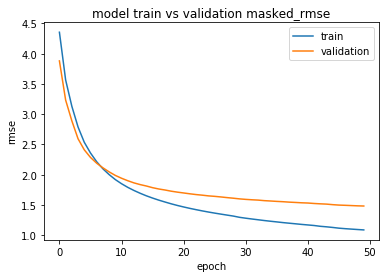

In [129]:
show_rmse(train_hist, 0)

In [130]:
pred = model.predict(train_np)

In [136]:
pred[0]

array([4.8681393, 3.0010002, 3.4693606, ..., 2.939014 , 3.2252648,
       3.840281 ], dtype=float32)

In [135]:
train_np[0]

array([5., 0., 0., ..., 0., 0., 0.])